### Hybrid Propulsion System Model

**Overview**
- Four propeller pods
- Two electric motors and one gas turbine per pod, connected mechanically via gearbox
- Gas turbine capable of charging the batteries via the electric motor


**Key Inputs**
- *Thrust required*: mission thrust required of each pod, according to flight profile (speed, altitude, flight path)
- *Pod Shaft Power Required* ($P_{\mathrm{pod}}$): computed via propeller momentum theory model.
- *GT Throttle Ratio* ($\lambda_{\mathrm{GT,pod}}$): ratio between the power supplied by the gas turbine and the power required by the pod. Can be set for each pod independently. 

$$
\lambda_{\mathrm{GT,pod}} = \frac{P_{\mathrm{gt}}}{P_{\mathrm{pod}}}
$$

Where:
- $\lambda_{\mathrm{GT,pod}} = 1$: Conventional mode (GT power only)
- $\lambda_{\mathrm{GT,pod}} < 1$: Hybrid mode (GT and E-motor power)
- $\lambda_{\mathrm{GT,pod}} > 1$: Generation mode (GT charges batteries via E-motor)

**Key Outputs**
$$
\begin{align*}
P_{\mathrm{gt}} &= \lambda_{\mathrm{GT,pod}} \times P_{\mathrm{pod}} \\
\lambda_{\mathrm{GT}} &= \frac{P_{\mathrm{gt}}}{P_{\mathrm{gt,max}}} \\
P_{\mathrm{e}} &= P_{\mathrm{pod}} - P_{\mathrm{gt}} \\
\lambda_{\mathrm{motor}} &= \frac{P_{\mathrm{e}}}{N_{\mathrm{motors}} \times P_{\mathrm{motor,max}}} \\
\gamma &= \frac{P_{\mathrm{e}}}{P_{\mathrm{pod}}}
\end{align*}
$$

**Where**
- $P_{\mathrm{gt}}$: Gas turbine mechanical power per pod
- $P_{\mathrm{e}}$: Total Electric motor mechanical power per pod
- $N_{\mathrm{motors}}$: Number of electric motors per pod
- $\lambda_{\mathrm{GT}}$: Gas turbine throttle (0 to 1)
- $\lambda_{\mathrm{motor}}$: Electric motor throttle (0 to 1)
- $\gamma$: Hybridization factor (-1 to 1)
  - $\gamma > 0$: Electric motors providing power
  - $\gamma < 0$: Electric motors receiving power (battery charging)
  - $\gamma = 0$: Pure gas turbine operation

In [16]:
# Import Packages
import openmdao.api as om
import numpy as np

import pdb 
import matplotlib.pyplot as plt
from plot_results import PlotData
from computepropeller import ComputePropeller
from computeamos import ComputeAtmos
from grouphybridpod import GroupPods


In [17]:

""" 
Setup Model
"""

# Define number of analysis points
nn = 30  # Single point analysis


# Define Aircraft Parameters
mtom_lb = 85000 
mtom_kg = mtom_lb * 0.453592
g = 9.806
l_d = 17
num_pods = 4

# Build Climb Profile
len_climb = int(np.floor(nn/2-1))
x = np.arange(len_climb)

# Consider an exponential decresae fom 9% to 0.5%

x0 = 0.5 # final climb angle gradient
x1 = 9 # initial climb angle gradient
k = 3 # decay rate 

r = x1 - x0
climb_ang_grad =  x0 + r * np.exp(-k * x / len_climb)
climb_ang_rad = np.arctan(climb_ang_grad/100)   

descent_ang_grad = -5
descent_ang_rad = np.arctan(descent_ang_grad/100)

gamma_climb = climb_ang_rad * np.ones(len_climb)
len_descent = len_climb
gamma_descent = descent_ang_rad * np.ones(len_descent)
gamma_cruise = 0 * np.ones(nn - len_climb - len_descent)
gamma_mission = np.concatenate([gamma_climb, gamma_cruise, gamma_descent])


# Build thrust profile
thrust_idle = 1000 * np.ones(nn)
thrust_calc = mtom_kg * g * (1/ l_d + np.sin(gamma_mission))
thrust_total = np.where(thrust_calc > thrust_idle, thrust_calc, thrust_idle)
thrust_pod = thrust_total / num_pods


# Build GT Throttle ratio profile
# Consider a logarithmic increase form 0.6 to 1.0
x0 = 0.6 # minimum throttle ratio
x1 = 0.9 # maximum throttle ratio

r = x1 - x0 # range of throttle ratio
y = x0 + r * (np.log(np.arange(int(np.floor(nn/2-1))) + 1) / np.log(int(np.floor(nn/2-1))))

gt_throttle_ratio_clb = y # throttle ratio for climb
gt_throttle_ratio_des =  1.4 * np.ones(int(np.floor(nn/2-1)))
gt_throttle_ratio_cru =  np.ones(nn - len(gt_throttle_ratio_clb) - len(gt_throttle_ratio_des))
gt_throttle_ratio_mission = np.concatenate([gt_throttle_ratio_clb, gt_throttle_ratio_cru, gt_throttle_ratio_des])



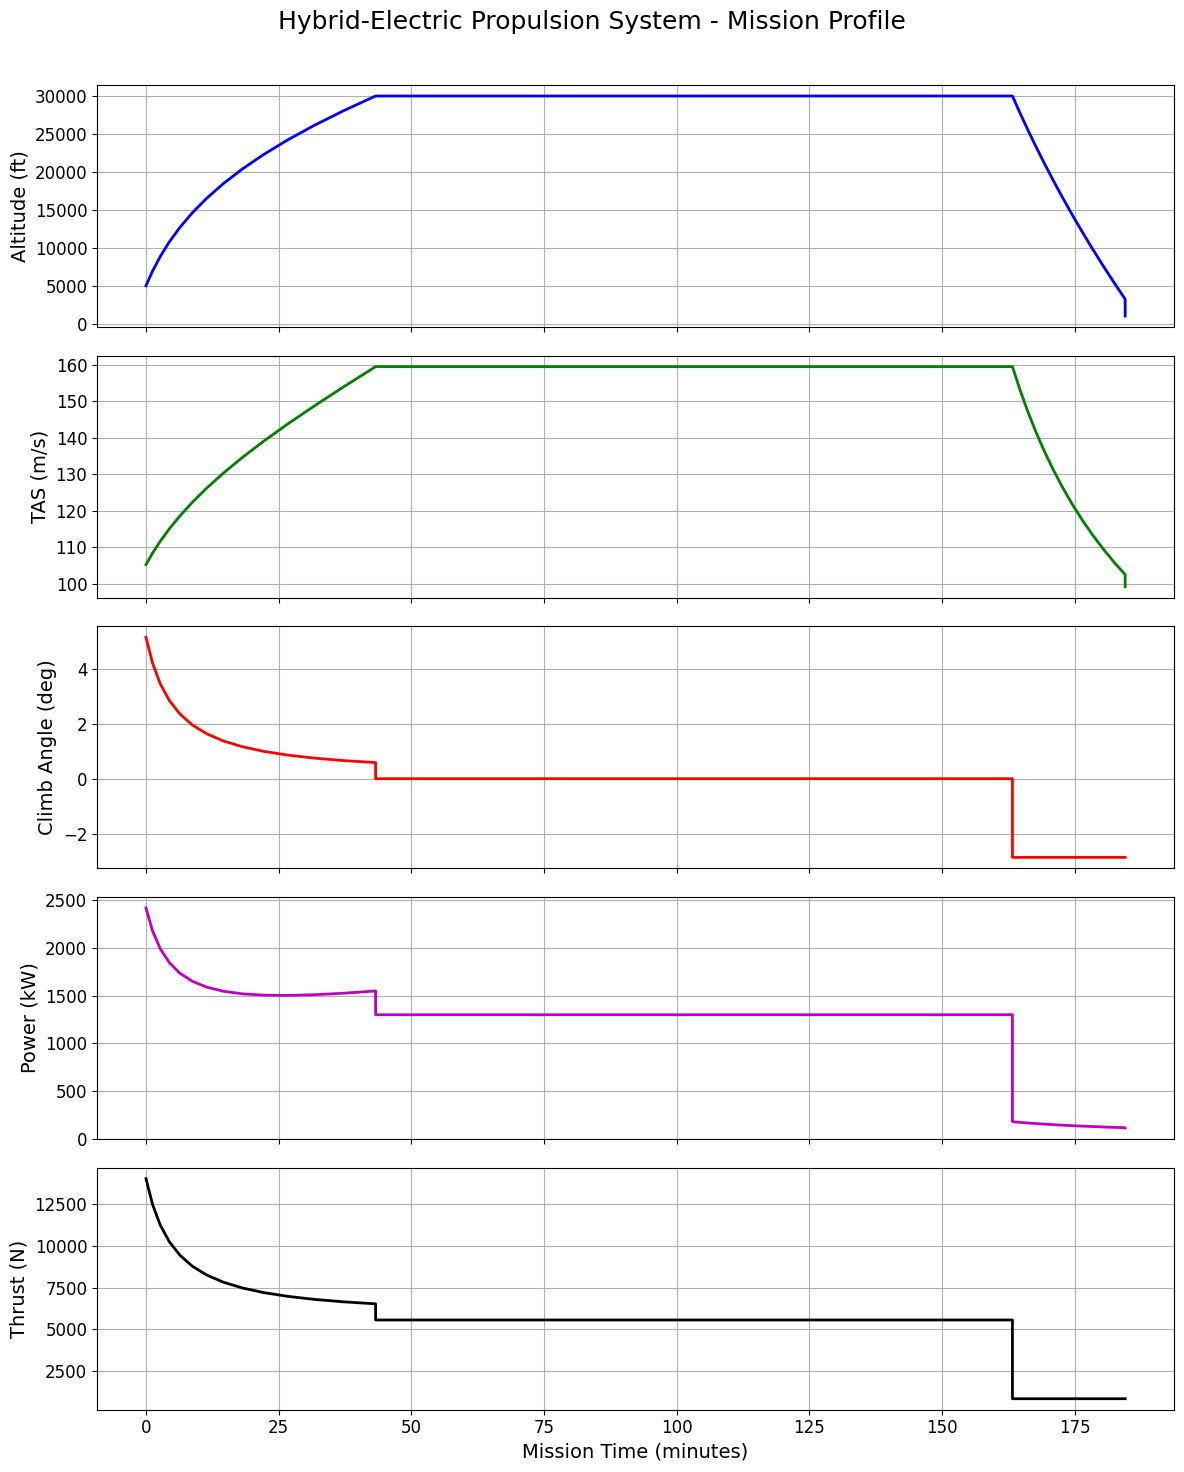

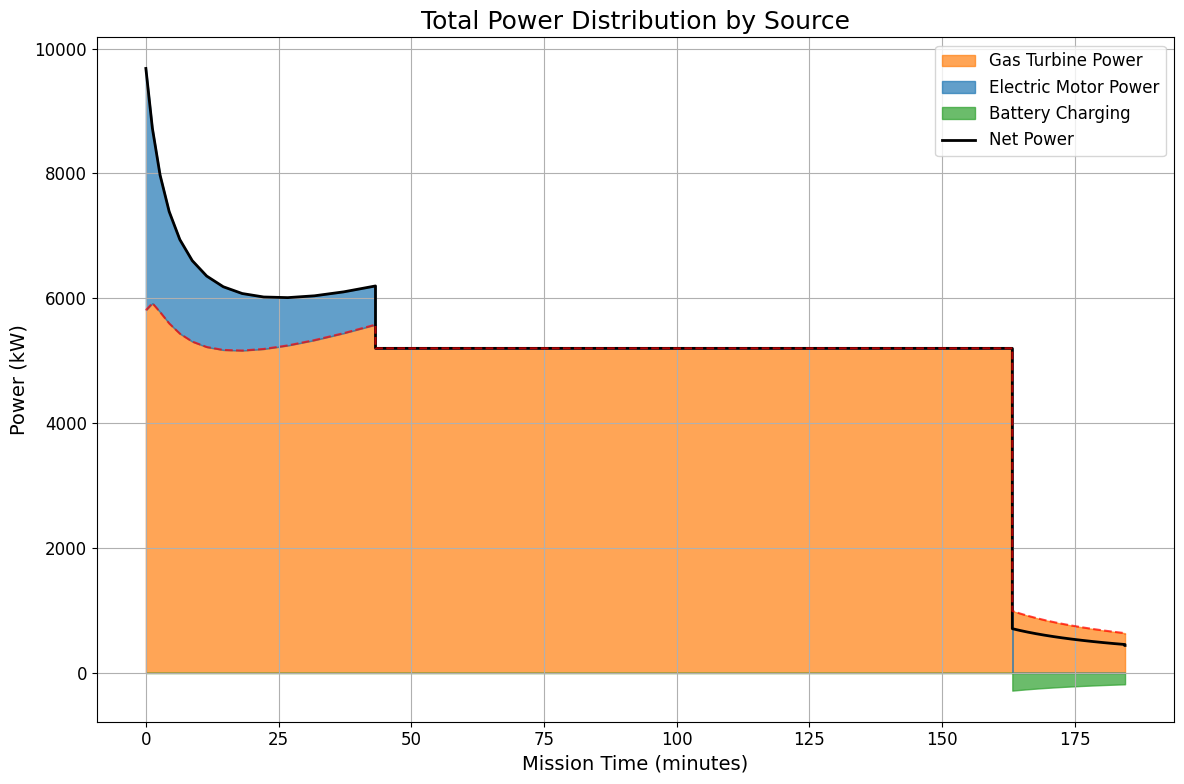

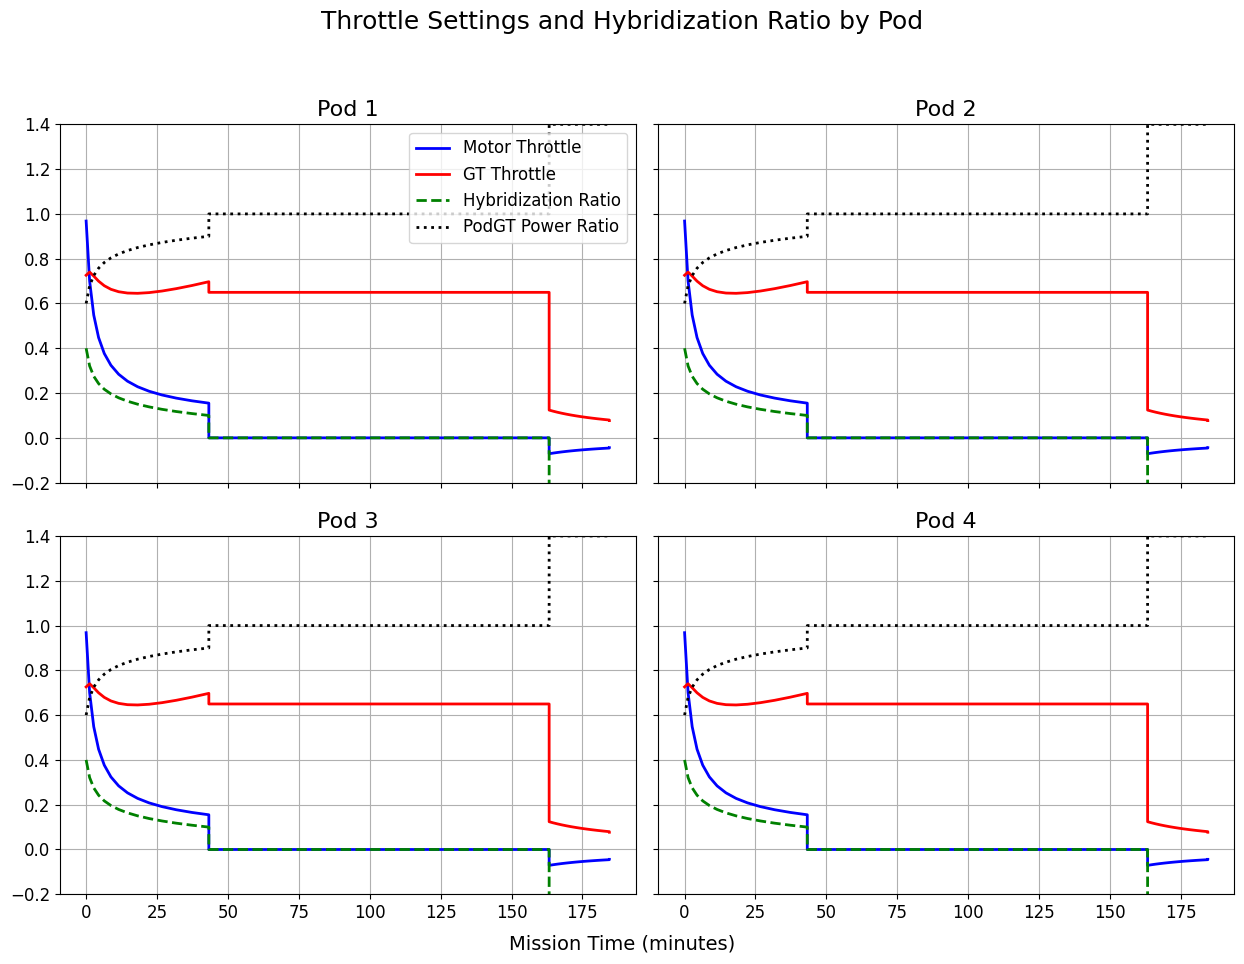

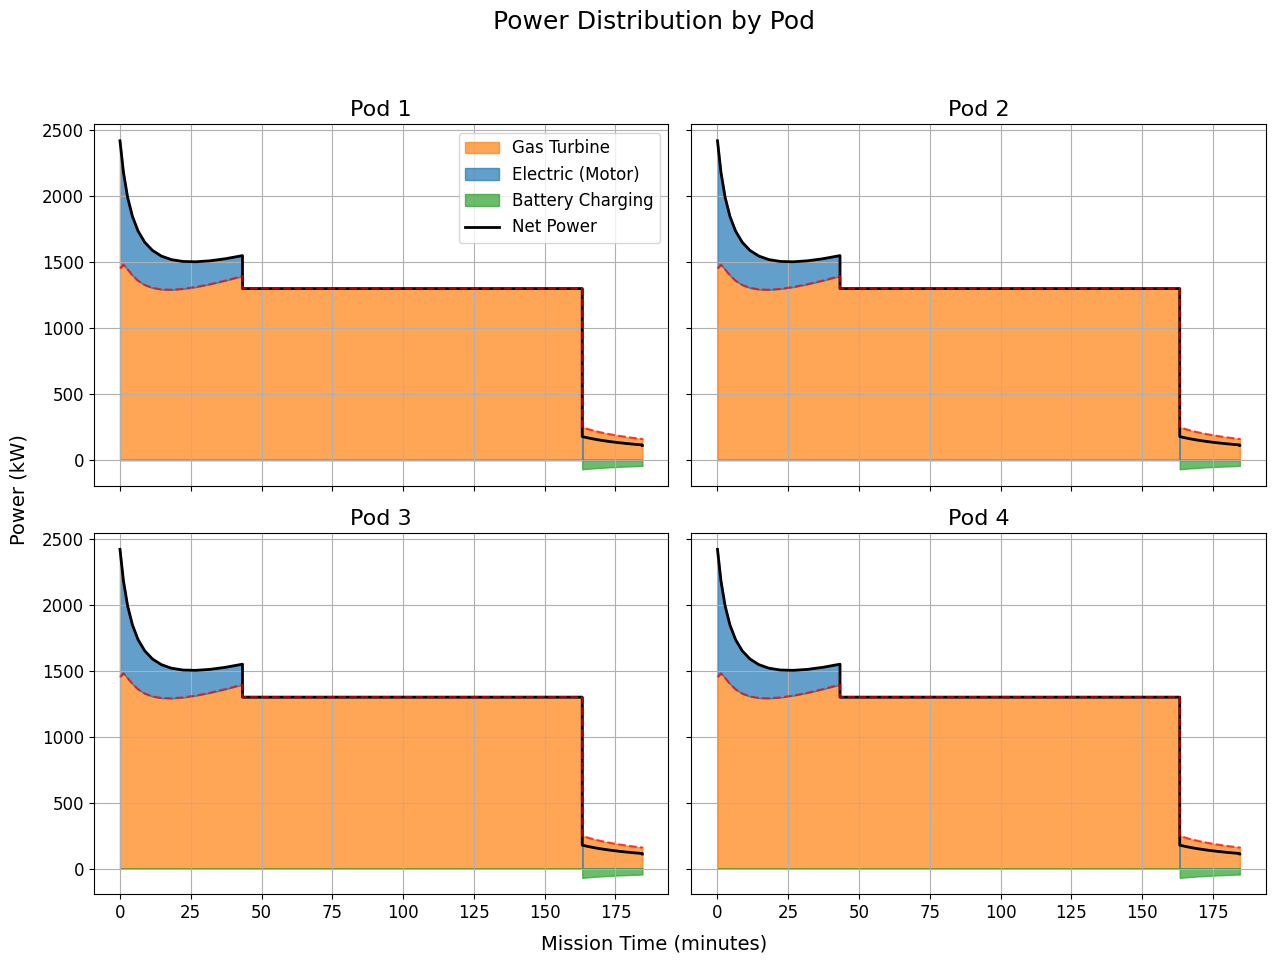

In [18]:

# Create the OpenMDAO problem
prob = om.Problem(reports=False)
ivc = om.IndepVarComp()

# Speed 
ivc.add_output('eas', val=190 * np.ones(nn), units='kn')

# GT Throttle Ratio
ivc.add_output('gt_throttle_ratio_mission', val=gt_throttle_ratio_mission)

# Define pod paaramters
pop_diam_m = 4.2
prop_hub_m = 0.75
eta_prop  = 0.8
max_motor_pow_W = 5e5
max_gt_pow_W = 2e6

for i in range(num_pods):
    # Propeller parameters
    ivc.add_output(f'pod{i+1}|blade_diam', pop_diam_m * np.ones(nn), units='m')
    ivc.add_output(f'pod{i+1}|hub_diam', prop_hub_m * np.ones(nn), units='m')
    ivc.add_output(f'pod{i+1}|thrust_req', thrust_pod * np.ones(nn), units='N')
    ivc.add_output(f'pod{i+1}|eta_prop', eta_prop * np.ones(nn), units=None)

    # Pod power parameters
    ivc.add_output(f'pod{i+1}|gt_throttle_ratio', val=gt_throttle_ratio_mission)
    ivc.add_output(f'pod{i+1}|max_motor_pow', val=max_motor_pow_W * np.ones(nn), units='W')
    ivc.add_output(f'pod{i+1}|max_gt_pow', val=max_gt_pow_W * np.ones(nn), units='W')

# Build flight profile 
alt_climb = np.linspace(5000, 30000, int(np.floor(nn/2-1)))
alt_descent = np.linspace(30000, 1000, int(np.floor(nn/2-1)))
alt_cruise = np.ones(nn-len(alt_climb)-len(alt_descent)) * 30000

len_crz = len(alt_cruise)
len_des = len(alt_descent)
len_clb = len(alt_climb)

alt = np.concatenate([alt_climb, alt_cruise, alt_descent])

ivc.add_output('alt', val=alt, units='ft')

# Connect to group
prob.model.add_subsystem('inputs', ivc, promotes_outputs=['*'])
prob.model.add_subsystem('hybrid_pod', 
                        GroupPods(nn=nn),
                        promotes_inputs=['*'], promotes_outputs=['*'])

# Setup the problem
prob.setup()

#om.n2(prob)
#prob.check_partials(compact_print=True)

# Run the analysis
prob.run_model()

plot_data = PlotData(prob, 
                     len_clb = len_clb, 
                     len_crz = len_crz, 
                     gamma_climb = gamma_climb, 
                     gamma_descent = gamma_descent,
                     gamma_mission = gamma_mission, 
                     nn = nn, 
                     num_pods = num_pods)
plot_data.plot_results(prob)
